# 近隣の飲食店が集まる場所を調査するエージェント

このノートブックでは、LangChain と LangGraph を使って複雑な Agent Workflow を構築します。

## 構築するワークフロー

近隣の飲食店が集まる場所を調査するエージェント

- ツール: web api 機能付きのモデルを使用して回答を得るツール
- エージェント: 駅近隣のエリアを網羅的に調査。調査は段階的に実行し、ツールのパラメータを変更しながら調査範囲を変更する。パラメータには指定範囲が存在。
- 終了条件: 新規情報が出にくくなる・最大繰り返し数を超えるのいずれかを満たしたと判断した時


In [32]:
# 必要なライブラリのインポート
import os
import json

from typing import List, Dict, Any, Annotated
from dotenv import load_dotenv
from IPython.display import Image

# LangChain imports
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

# LangGraph imports
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# 環境変数読み込み
load_dotenv()

print("📦 ライブラリインポート完了（LangGraph reducer機能追加）")

# API キー確認
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if OPENAI_API_KEY:
    print("✅ OpenAI APIキーが設定されています")
    print("🔍 gpt-5-search-api使用可能")
else:
    print("⚠️ OpenAI APIキーが設定されていません")
    print("💡 OpenAI APIキーの設定方法:")
    print("   1. https://platform.openai.com でアカウント作成")
    print("   2. API Keysセクションで新しいキーを作成")
    print("   3. .envファイルにOPENAI_API_KEY=your_key_hereを追記")

📦 ライブラリインポート完了（LangGraph reducer機能追加）
✅ OpenAI APIキーが設定されています
🔍 gpt-5-search-api使用可能


In [33]:
# State定義 - 適応的飲食店調査エージェント用データ構造（LangGraph reducer機能使用）
from pydantic import BaseModel, Field, ConfigDict
from langgraph.graph import MessagesState


# LangGraph用のカスタムreducer関数（説明文付き）
def merge_survey_history(existing: List, new: List) -> List:
    """各回の調査サマリー履歴を結合する"""
    return existing + new


def merge_areas(existing: List, new: List) -> List:
    """発見した飲食店エリアのリストを結合する"""
    return existing + new


def merge_errors(existing: List, new: List) -> List:
    """処理エラーのリストを結合する"""
    return existing + new


# 飲食店情報のPydanticモデル
class Restaurant(BaseModel):
    model_config = ConfigDict(from_attributes=True)

    name: str = Field(..., description="店舗名")
    category: str = Field(..., description="業態カテゴリ（カフェ、レストラン、居酒屋など）")
    walking_minutes: int = Field(..., description="駅からの徒歩時間（分）")
    location: str = Field(..., description="具体的な場所・住所")
    area_name: str = Field(..., description="所属するエリア名（商店街名など）")
    features: List[str] = Field(..., description="特徴・売りポイント")
    price_range: str = Field(..., description="価格帯（低/中/高）")
    business_hours: str = Field(..., description="営業時間")
    sns_appeal_points: List[str] = Field(..., description="SNSアピールポイント（映えるポイント、話題性など）")
    source_url: str = Field(default="", description="情報源URL")


# エリア情報の集約モデル
class FoodArea(BaseModel):
    model_config = ConfigDict(from_attributes=True)

    area_name: str = Field(..., description="エリア名")
    walking_minutes_range: str = Field(..., description="駅からの徒歩時間範囲（例: 3-7分）")
    main_categories: List[str] = Field(..., description="主要な飲食店カテゴリ")
    area_characteristics: str = Field(..., description="エリアの特徴・雰囲気")
    sns_highlights: List[str] = Field(..., description="SNS発信用のエリアハイライト")
    instagrammable_spots: List[str] = Field(..., description="インスタ映えするスポット・特徴")
    restaurants: List[Restaurant] = Field(..., description="エリア内の飲食店リスト")


# 各回の調査サマリー
class SurveySummary(BaseModel):
    model_config = ConfigDict(from_attributes=True)

    iteration_number: int = Field(..., description="調査回数")
    search_strategy: str = Field(..., description="その回の調査戦略")
    new_restaurants_count: int = Field(..., description="新規発見店舗数")
    new_areas_found: List[FoodArea] = Field(..., description="新規発見エリア名リスト")
    key_discoveries: List[str] = Field(..., description="その回の主要発見事項")
    geographical_coverage: str = Field(..., description="その回でカバーした地理的範囲")


# LLM用の調査サマリー生成レスポンス
class SurveySummaryGeneration(BaseModel):
    """調査サマリー生成用の構造化レスポンス"""

    model_config = ConfigDict(from_attributes=True)

    new_restaurants_count: int = Field(..., description="この回で新たに発見した店舗数")
    new_areas_found: List[FoodArea] = Field(
        ..., description="この回で新たに発見したエリア名リスト (重複は除外すること)"
    )
    key_discoveries: List[str] = Field(..., description="この回の主要な発見事項（3-5個の具体的な洞察）")
    geographical_coverage: str = Field(..., description="地理的カバレッジの説明（この回でカバーした範囲）")


# LLM用の分析ノードレスポンス
class AnalysisNodeResponse(BaseModel):
    """分析ノード用の構造化レスポンス"""

    model_config = ConfigDict(from_attributes=True)

    continue_survey: bool = Field(..., description="調査を継続すべきかどうか")
    continuation_reason: str = Field(..., description="継続・終了の理由")
    survey_evaluation: str = Field(..., description="累積調査の評価（良好/普通/要改善）")
    coverage_gaps: List[str] = Field(..., description="調査不足と思われる領域")
    next_strategy: str = Field(..., description="次回調査の具体的方針（継続の場合）")
    strategic_rationale: str = Field(..., description="戦略的根拠")
    priority_gaps: List[str] = Field(..., description="優先的に埋めるべき調査ギャップ")


# 調査結果の分析情報
class SurveyAnalysis(BaseModel):
    model_config = ConfigDict(from_attributes=True)

    geographical_coverage: str = Field(..., description="地理的カバレッジ分析（方角・範囲）")
    walking_time_distribution: str = Field(..., description="徒歩時間分布の傾向")
    category_distribution: str = Field(..., description="業態カテゴリの分布状況")
    sns_content_potential: str = Field(..., description="SNSコンテンツとしてのポテンシャル分析")
    coverage_gaps: List[str] = Field(..., description="調査不足と思われる領域")
    next_survey_strategy: str = Field(..., description="次回調査の推奨戦略")
    # 新規追加：累積調査の要約
    cumulative_summary: str = Field(..., description="初回〜現在までの調査全体の要約")
    unexplored_potential: List[str] = Field(..., description="未調査の可能性が高い領域・業態・条件")


# 次回調査指示
class NextSurveyPlan(BaseModel):
    model_config = ConfigDict(from_attributes=True)

    focus_area: str = Field(..., description="重点調査エリア（方角・距離）")
    target_categories: List[str] = Field(..., description="重点調査する業態")
    walking_time_range: str = Field(..., description="重点調査する徒歩時間範囲")
    sns_focus_points: List[str] = Field(..., description="SNS観点で重視する調査ポイント")
    exclusion_criteria: str = Field(..., description="既に調査済みのため除外する条件")
    search_query: str = Field(
        ...,
        description="次回調査用の検索クエリ（調査エリア・業態・徒歩分数・SNS観点をまとめる）",
    )
    # 新規追加：累積調査を考慮した戦略的要素
    strategic_rationale: str = Field(..., description="累積調査結果を踏まえた戦略的根拠")
    priority_gaps: List[str] = Field(..., description="優先的に埋めるべき調査ギャップ")


# MessagesStateを継承したエージェント状態管理（説明文付きLangGraph reducer使用）
class RestaurantSurveyState(MessagesState):
    # 入力パラメータ
    station_name: Annotated[str, "調査対象の駅名"]
    max_iterations: Annotated[int, "最大調査回数"]

    # 調査結果の蓄積（説明文付きカスタムreducerで自動結合）
    survey_iteration: Annotated[int, "現在の調査回数"]
    discovered_areas: Annotated[List[FoodArea], merge_areas]

    # 調査履歴の管理（説明文付きカスタムreducerで自動結合）
    survey_history: Annotated[List[SurveySummary], merge_survey_history]

    # 各イテレーションの分析結果
    current_analysis: Annotated[SurveyAnalysis, "現在の調査結果分析"]
    next_plan: Annotated[NextSurveyPlan, "次回調査計画"]

    # 制御フラグ
    current_process: Annotated[str, "現在の処理名"]
    should_continue: Annotated[bool, "調査を継続するか"]
    completion_reason: Annotated[str, "調査完了の理由"]
    processing_errors: Annotated[List[str], merge_errors]


print("🍽️ SNS特化適応的飲食店調査エージェント用State定義完了（説明文付きLangGraph reducer使用）")

🍽️ SNS特化適応的飲食店調査エージェント用State定義完了（説明文付きLangGraph reducer使用）


In [34]:
# 構造化出力用のResponseSchema（FoodArea中心）
class FoodAreaSearchResponse(BaseModel):
    """飲食店エリア検索結果の構造化レスポンス"""

    model_config = ConfigDict(from_attributes=True)

    discovered_areas: List[FoodArea] = Field(..., description="発見した飲食店エリアのリスト")
    search_summary: str = Field(..., description="検索結果の要約")
    total_areas_found: int = Field(..., description="発見したエリア総数")
    search_area_coverage: str = Field(..., description="検索でカバーしたエリアの説明")
    sns_highlights: List[str] = Field(..., description="特にSNS映えする要素のハイライト")
    exclusion_applied: bool = Field(..., description="除外条件が適用されたかどうか")
    data_reliability: str = Field(..., description="データの信頼性評価（高/中/低）")


@tool
def search_food_areas_with_web_api(
    station_name: str, search_query: str, exclusion_criteria: str = ""
) -> FoodAreaSearchResponse:
    """Web API機能付きモデルで飲食店エリア情報を検索（SNS向け特化、エリア単位の構造化出力）"""
    # gpt-5-search-api を使用してリアルタイム検索（エリア単位の構造化出力）
    search_llm = ChatOpenAI(model="gpt-5-search-api", temperature=0.1)
    structured_llm = search_llm.with_structured_output(FoodAreaSearchResponse)

    search_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
あなたはSNS向け飲食店エリア専門リサーチャーです。
Web検索機能を使って、指定された駅周辺の飲食店エリア情報を事実ベースで調査し、
**エリア単位でまとめた構造化レスポンス**として返してください。


🎯 SNS特化エリア単位調査ポイント：
1. 商店街・食べ歩きエリア・グルメ街の特定
2. エリア内の代表的な飲食店の情報（店舗名・業態・価格帯・営業時間）
3. エリア全体の特徴・雰囲気・コンセプト
4. 駅からのアクセス情報（徒歩時間範囲）
5. エリア全体のSNSアピールポイント（統一感のある内装、街並み、フォトスポット、話題のメニューなど）
6. エリアの話題性・人気度（メディア露出、観光地化、地元密着度など）
7. エリア全体でのSNS投稿価値（テーマ性、回遊性、撮影スポットの豊富さ）
8. 信頼できる情報源（Google口コミ、SNS投稿、観光サイト、グルメサイト、地域情報など）

📋 エリア単位データ要件：
- 各エリアに3-8店舗程度を含める
- エリアの徒歩時間範囲を明確に
- エリアごとのSNS特化要素を具体的に（例：「レトロ商店街の統一看板」「カフェ街の緑豊かな雰囲気」）
- 除外条件が指定されている場合は厳格に適用
- エリア情報の信頼性を評価

**重要**: 個別店舗ではなく、飲食店が集積する「エリア」を中心に調査・整理してください。
            """,
            ),
            (
                "user",
                """
駅名: {station_name}
調査内容: {search_query}
除外条件: {exclusion_criteria}

上記の条件でSNS向け飲食店エリア調査を実行し、**エリア単位でまとめた**構造化レスポンスで返してください。
特に以下を重視：
- エリアごとの飲食店集積状況
- エリア全体のインスタ映えするビジュアル要素
- エリアの統一感・テーマ性・話題性
- 各エリア内の代表店舗情報
- データの信頼性と正確性
            """,
            ),
        ]
    )

    chain = search_prompt | structured_llm
    response = chain.invoke(
        {
            "station_name": station_name,
            "search_query": search_query,
            "exclusion_criteria": exclusion_criteria or "なし",
        }
    )

    print("  🔍 飲食店エリア検索完了: ")
    print(f"    - 発見エリア数: {response.total_areas_found}")
    print(f"    - 検索カバレッジ: {response.search_area_coverage.strip()}")
    print(f"    - 除外条件適用: {'はい' if response.exclusion_applied else 'いいえ'}")
    print(f"    - データ信頼性: {response.data_reliability}")

    return response


# ツールリスト（エリア単位構造化出力対応）
restaurant_tools = [search_food_areas_with_web_api]

print("🔧 SNS特化適応的飲食店エリア調査ツール定義完了（エリア単位構造化出力対応）")


🔧 SNS特化適応的飲食店エリア調査ツール定義完了（エリア単位構造化出力対応）


In [35]:
# Node 1: SNS特化飲食店調査実行ノード（LangGraph reducer対応・エリア単位・LLMベースのサマリー生成）
def restaurant_survey_node(state: RestaurantSurveyState) -> RestaurantSurveyState:
    """現在の調査戦略に基づいて飲食店エリア情報を収集（SNS特化・エリア単位）"""
    print(f"🔍 SNS特化飲食店エリア調査実行ノード開始 (第{state['survey_iteration'] + 1}回)")

    # 次回調査の検索パラメータ取得
    search_params = _get_search_params(state)
    # Web API検索実行（エリア単位の構造化出力）
    search_response = search_food_areas_with_web_api.invoke(
        {
            "station_name": search_params["station_name"],
            "search_query": search_params["search_query"],
            "exclusion_criteria": search_params["exclusion_criteria"],
        }
    )

    # LLMを使用してSurveySummaryを生成
    survey_summary = _generate_survey_summary_with_llm(
        state=state, search_response=search_response, search_params=search_params
    )

    # LangGraph reducer対応：新しい要素をreturnで返す
    result = {
        "current_process": "restaurant_survey_node",
        "survey_iteration": state["survey_iteration"] + 1,
        "discovered_areas": survey_summary.new_areas_found,  # 自動的に既存リストに結合される
        "survey_history": [survey_summary],  # 自動的に既存リストに結合される
    }

    print(f"  📚 調査履歴: {len(state['survey_history']) + 1}回分蓄積")

    return result


def _generate_survey_summary_with_llm(
    state: RestaurantSurveyState, search_response: FoodAreaSearchResponse, search_params: Dict[str, Any]
) -> SurveySummary:
    """LLMを使用してSurveySummaryを生成する（with_structured_output使用）"""

    search_result = (
        json.dumps(search_response.model_dump(), indent=2, ensure_ascii=False).replace("{", "{{").replace("}", "}}")
    )
    survey_history = "\n,".join(
        [
            json.dumps(sh.model_dump(), indent=2, ensure_ascii=False).replace("{", "{{").replace("}", "}}")
            for sh in state["survey_history"]
        ]
    )

    # 構造化出力を使用するLLM
    summary_llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
    structured_llm = summary_llm.with_structured_output(SurveySummaryGeneration)

    # 構造化出力用プロンプトの構築
    summary_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
調査データを分析し、この回の調査サマリーを構造化された形式で生成してください。

🎯 調査サマリー生成の観点：
1. この回の調査戦略の効果と成果
2. 新規発見したエリア・店舗の特徴と価値
3. SNS観点での発見事項・魅力度
4. 地理的・業態的な発見パターン
5. 前回までとの比較での新規性・独自性
📋 構造化出力要件：
- key_discoveries: この回の主要な発見事項（3-5個の具体的で洞察に富んだ分析）
- geographical_coverage: この回でカバーした地理的範囲の説明
- 具体的でSNS特化観点を重視した内容
- 単純な数値羅列や一般的表現を避ける
            """,
            ),
            (
                "user",
                f"""
【調査情報】
駅名: {state["station_name"]}
調査回数: 第{state["survey_iteration"] + 1}回
調査戦略: {search_params["search_query"]}
除外条件: {search_params.get("exclusion_criteria", "なし")}

【今回の成果】
```json
{search_result}
```

【既存調査履歴】
```json
{survey_history}
```

上記の情報を分析し、この回の調査で得られた重要な発見事項と地理的カバレッジを教えてください。
上記の調査情報を分析し、SNS観点での魅力や前回調査との比較での新規性に注目して、
key_discoveriesとgeographical_coverageを構造化された形式で出力してください。
            """,
            ),
        ]
    )

    # 構造化LLMチェーンを実行
    chain = summary_prompt | structured_llm
    analysis_result = chain.invoke({})

    print("  📝 調査サマリー生成完了: ")
    print(f"    - 新規発見店舗数: {analysis_result.new_restaurants_count}")
    print(f"    - 新規発見エリア: {analysis_result.new_areas_found}")
    print(f"    - 主要な発見事項: {analysis_result.key_discoveries}")
    print(f"    - 地理的カバレッジ: {analysis_result.geographical_coverage.strip()}")

    return SurveySummary(
        iteration_number=state["survey_iteration"] + 1,
        search_strategy=search_params["search_query"],
        new_restaurants_count=analysis_result.new_restaurants_count,
        new_areas_found=analysis_result.new_areas_found,
        key_discoveries=analysis_result.key_discoveries,
        geographical_coverage=analysis_result.geographical_coverage.strip(),
    )


def _get_search_params(state: RestaurantSurveyState) -> Dict[str, Any]:
    """次回調査の検索パラメータを取得（補助関数・エリア中心）"""
    # 初回調査の場合はエリア基本調査
    if state["survey_iteration"] == 0:
        search_query = f"{state['station_name']}周辺の飲食店が集まるエリア・商店街・グルメスポットを調査。SNS映えするエリアを優先し、各エリア内の代表店舗情報も含めて収集"
        exclusion_criteria = ""
        focus_area = f"{state['station_name']}駅周辺全般"
    else:
        # 2回目以降は戦略的調査
        search_query = state["next_plan"].search_query
        exclusion_criteria = state["next_plan"].exclusion_criteria
        focus_area = state["next_plan"].focus_area

    print(f"  📋 調査クエリ: {search_query}")
    print(f"  📍 重点エリア: {focus_area}")
    print(f"   除外条件: {exclusion_criteria or 'なし'}")
    return {
        "station_name": state["station_name"],
        "search_query": search_query,
        "exclusion_criteria": exclusion_criteria,
        "focus_area": focus_area,
    }

In [36]:
phase1_debug = False
if phase1_debug:
    # シンプルなワークフローの構築（テスト用）
    workflow_1 = StateGraph(RestaurantSurveyState)
    workflow_1.add_node("restaurant_survey_node", restaurant_survey_node)
    workflow_1.set_entry_point("restaurant_survey_node")

    # 調査実行後は終了
    workflow_1.add_edge("restaurant_survey_node", END)

    # グラフコンパイル
    simple_survey_app_1 = workflow_1.compile()

    print("🔧 シンプルな飲食店調査ワークフロー構築完了")

    result_1 = simple_survey_app_1.invoke(
        {
            "station_name": "天王町",
            "max_iterations": 1,
            "survey_iteration": 0,
            "messages": [HumanMessage(content="調査を開始")],
        }
    )

    print(result_1["discovered_areas"])
    print(result_1["survey_history"])


In [37]:
# Node 2: 結果分析＆次回戦略立案ノード（累積調査履歴分析機能追加）
def analysis_and_planning_node(state: RestaurantSurveyState) -> RestaurantSurveyState:
    """前回までの調査結果を分析し、次回調査戦略を立案（累積履歴を考慮）"""
    print("🧠 分析＆戦略立案ノード開始（累積調査履歴分析）")

    # 構造化出力を使用するLLM
    analysis_llm = ChatOpenAI(model="gpt-5.1", temperature=0)
    structured_analysis_llm = analysis_llm.with_structured_output(AnalysisNodeResponse)

    # 現在の調査結果をサマリー
    survey_history_summary = []
    for i_survey_history in state["survey_history"]:
        i_survey_history_dump = i_survey_history.model_dump()

        i_mnew_areas_found_summary = "\n".join(
            ["- " + i_new_area_found["area_name"] for i_new_area_found in i_survey_history_dump["new_areas_found"]]
        )
        i_survey_summary = f"""
## 調査回数: 第{i_survey_history_dump["iteration_number"]}回
    【検索クエリ】
    {i_survey_history_dump["search_strategy"]}

    【検索結果で取得できたエリア】
    {i_mnew_areas_found_summary}

    【検索結果の地理的範囲】
    {i_survey_history_dump["geographical_coverage"]}

        """
        survey_history_summary.append(i_survey_summary)

    # 調査履歴の要約生成
    survey_history_summary = "\n".join(survey_history_summary)

    analysis_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
あなたは飲食店調査の戦略アナリストです。
累積的な調査履歴を詳細に分析し、包括的な調査継続判定と次回戦略を決定してください。

累積調査分析観点：
1. 地理的カバレッジ（方角・距離範囲の網羅性）
2. 徒歩時間帯の偏り分析
3. 業態カテゴリの網羅性 
4. 価格帯・客層の多様性
5. SNSコンテンツとしての魅力度
6. 各回の調査戦略の効果分析
7. 未調査領域の特定

継続判定基準：
- 新規情報発見の可能性（地理的・業態的ギャップ）
- 調査品質の向上余地
- SNSコンテンツとしての充実度
- 最大回数との関係

次回戦略立案：
- これまでの調査履歴で見落とした領域
- 戦略的に重要な未調査エリア
- SNS観点で不足している要素
- 除外すべき既調査内容の詳細
- 調査効率を高める具体的アプローチ

結果を以下の形式で出力：
1. 【継続判定】Yes/No + 理由
2. 【累積調査の評価】良好/普通/要改善 + 根拠
3. 【未調査ギャップ分析】具体的な不足領域
4. 【次回戦略】継続の場合の具体的調査方針
            """,
            ),
            (
                "user",
                f"""
駅名: {state["station_name"]}
最大調査回数: {state["max_iterations"]}

{survey_history_summary}

上記の累積調査結果を多角的に分析し、以下を詳細に判定してください：

1. 調査継続の必要性と根拠
2. これまでの調査履歴での戦略効果分析
3. 未調査領域の具体的特定
4. SNSコンテンツ観点での充実度評価
5. 次回調査戦略（継続の場合）

特に累積的な視点で、これまでの調査で取りこぼしている可能性がある領域を重視してください。
            """,
            ),
        ]
    )

    # 構造化分析の実行
    chain = analysis_prompt | structured_analysis_llm
    analysis_result = chain.invoke({})

    print("  🧾 分析＆戦略立案完了: ")
    print(f"    - 調査継続判定: {'継続' if analysis_result.continue_survey else '終了'}")
    print(f"    - 継続・終了理由: {analysis_result.continuation_reason[:100]}...")
    print(f"    - 累積調査評価: {analysis_result.survey_evaluation}")
    print(f"    - 未調査ギャップ: {analysis_result.coverage_gaps}")
    print(f"    - 次回調査方針: {analysis_result.next_strategy.strip()[:100]}...")

    # 構造化出力から継続判定を取得
    should_continue = analysis_result.continue_survey and state["survey_iteration"] < state["max_iterations"]

    result = {}
    if should_continue:
        result["next_plan"] = _generate_next_plan_with_llm(state, analysis_result)
    else:
        result["completion_reason"] = analysis_result.continuation_reason

    result["current_process"] = "analysis_and_planning_node"
    result["should_continue"] = should_continue
    result["current_analysis"] = analysis_result

    return result


def _generate_next_plan_with_llm(state: RestaurantSurveyState, analysis_result: AnalysisNodeResponse) -> NextSurveyPlan:
    """LLMを使用してNextSurveyPlanを生成する（累積調査を考慮）"""

    analysis_detail = (
        json.dumps(analysis_result.model_dump(), indent=2, ensure_ascii=False).replace("{", "{{").replace("}", "}}")
    )

    # 構造化出力を使用するLLM
    plan_llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
    structured_plan_llm = plan_llm.with_structured_output(NextSurveyPlan)

    plan_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
あなたは飲食店調査の戦略プランナーです。
累積的な調査履歴と最新の分析結果を踏まえ、次回調査の具体的な戦略計画を立案してください。
累積調査考慮ポイント：
1. これまでの調査で見落とした可能性のある領域
2. 戦略的に重要な未調査エリア
3. SNS観点で不足している要素
4. 除外すべき既調査内容の詳細
5. 調査効率を高める具体的アプローチ

                """,
            ),
            (
                "user",
                f"""
駅名: {state["station_name"]}
最大調査回数: {state["max_iterations"]}

最新の分析結果:
{analysis_detail}

上記を踏まえ、次回調査の具体的な戦略計画を詳細に立案してください。
`search_query`と`exclusion_criteria`は次回の調査でChatGPTに指示するプロンプトの一部として使用します。

プロンプトは以下の形式です。
```prompt
駅名: station_name
調査内容: search_query
除外条件: exclusion_criteria

上記の条件でSNS向け飲食店エリア調査を実行し、**エリア単位でまとめた**構造化レスポンスで返してください。
特に以下を重視：
- エリアごとの飲食店集積状況
- エリア全体のインスタ映えするビジュアル要素
- エリアの統一感・テーマ性・話題性
- 各エリア内の代表店舗情報
- データの信頼性と正確性
```

`search_query`,`exclusion_criteria`がprompt内で自然に使用できるように200文字以内で出力してください。
                """,
            ),
        ]
    )

    # 構造化プラン生成の実行
    chain = plan_prompt | structured_plan_llm
    next_plan = chain.invoke({})

    print("  🗺️ 次回調査計画生成完了: ")
    print(f"    - 重点エリア: {next_plan.focus_area}")
    print(f"    - 重点業態: {next_plan.target_categories}")
    print(f"    - 徒歩時間範囲: {next_plan.walking_time_range}")
    print(f"    - SNS重視ポイント: {next_plan.sns_focus_points}")
    print(f"    - 除外条件: {next_plan.exclusion_criteria}")

    return next_plan


print("🧠 結果分析＆戦略立案ノード定義完了（累積調査履歴分析機能追加）")

🧠 結果分析＆戦略立案ノード定義完了（累積調査履歴分析機能追加）


In [38]:
phase2_debug = False

if phase2_debug:
    # シンプルなワークフローの構築（テスト用）
    workflow_2 = StateGraph(RestaurantSurveyState)
    workflow_2.add_node("analysis_and_planning_node", analysis_and_planning_node)
    workflow_2.set_entry_point("analysis_and_planning_node")

    # 調査実行後は終了
    workflow_2.add_edge("analysis_and_planning_node", END)

    # グラフコンパイル
    simple_survey_app_2 = workflow_2.compile()

    print("🔧 シンプルな飲食店調査ワークフロー構築完了")

    result_1_copy = result_1.copy()
    result_1_copy["max_iterations"] = 2
    result_2 = simple_survey_app_2.invoke(result_1_copy)

🔧 適応的飲食店調査LangGraphワークフロー構築完了

📊 ワークフロー構成:
  🔍 調査実行 → 🧠 分析＆戦略立案 → 📋 継続判定 → ループまたは終了


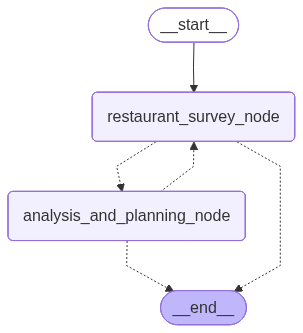

In [39]:
# 適応的調査の条件分岐関数
def should_continue_adaptive_survey(state: RestaurantSurveyState) -> str:
    """調査継続の判定"""

    # 最大回数超過の場合は終了
    if state["survey_iteration"] >= state["max_iterations"]:
        return END

    # 初回は`restaurant_survey_node`
    if "current_process" not in state or not state["current_process"]:
        return "restaurant_survey_node"

    # 現在の処理がある場合は、反対側の処理を実行
    if state["current_process"] == "restaurant_survey_node":
        return "analysis_and_planning_node"

    elif state["current_process"] == "analysis_and_planning_node":
        # 継続フラグが False の場合は終了
        if not state["should_continue"]:
            return END
        return "restaurant_survey_node"

    else:
        raise Exception(f"想定されないフローです: {state['current_process']}")


# LangGraphワークフロー構築
workflow = StateGraph(RestaurantSurveyState)

# ノードの追加
workflow.add_node("restaurant_survey_node", restaurant_survey_node)
workflow.add_node("analysis_and_planning_node", analysis_and_planning_node)

# ワークフローの定義
workflow.set_entry_point("restaurant_survey_node")

# 調査実行後は必ず分析へ
workflow.add_conditional_edges(
    "restaurant_survey_node",
    should_continue_adaptive_survey,
    {"analysis_and_planning_node": "analysis_and_planning_node", END: END},
)

# 分析後は継続判定に基づいて次回調査または終了
workflow.add_conditional_edges(
    "analysis_and_planning_node",
    should_continue_adaptive_survey,
    {"restaurant_survey_node": "restaurant_survey_node", END: END},
)

# メモリ設定
memory = MemorySaver()

# グラフコンパイル
adaptive_survey_app = workflow.compile(checkpointer=memory)

print("🔧 適応的飲食店調査LangGraphワークフロー構築完了")
print("\n📊 ワークフロー構成:")
print("  🔍 調査実行 → 🧠 分析＆戦略立案 → 📋 継続判定 → ループまたは終了")

Image(adaptive_survey_app.get_graph(xray=True).draw_mermaid_png())

In [40]:
station_name = "大井町"
max_iterations = 5
initial_state = {
    "station_name": station_name,
    "max_iterations": max_iterations,
    "survey_iteration": 0,
    "messages": [HumanMessage(content=f"{station_name}の適応的飲食店調査を開始してください")],
}
config = {"configurable": {"thread_id": f"{station_name}-adaptive-restaurant-survey"}}

result = adaptive_survey_app.invoke(initial_state, config)

🔍 SNS特化飲食店エリア調査実行ノード開始 (第1回)
  📋 調査クエリ: 大井町周辺の飲食店が集まるエリア・商店街・グルメスポットを調査。SNS映えするエリアを優先し、各エリア内の代表店舗情報も含めて収集
  📍 重点エリア: 大井町駅周辺全般
   除外条件: なし
  🔍 飲食店エリア検索完了: 
    - 発見エリア数: 4
    - 検索カバレッジ: 駅中心から阪急側・東側まで含むおよそ半径7分以内。全方向の主要飲食・商店街エリアをカバー。
    - 除外条件適用: いいえ
    - データ信頼性: 中高
  📝 調査サマリー生成完了: 
    - 新規発見店舗数: 9
    - 新規発見エリア: [FoodArea(area_name='東小路飲食店街 (Higashi-Kōji Yomise Gai)', walking_minutes_range='1-5分', main_categories=['立ち食い寿司', '居酒屋', '大衆酒場', '串焼き', '洋食'], area_characteristics='昭和レトロな横丁文化が色濃く残る迷路状の路地。赤ちょうちんや暖簾により夜間の視覚的インパクトが大きく、庶民的な酒場やボリューム系洋食が混在することで“安さと映え”のコントラストが強い。', sns_highlights=['提灯や暖簾を活かした夜の横丁フォトジェニック', '大きめネタの立ち食い寿司の断面ショットが映える', 'ネオ大衆酒場の内観・混雑感がストーリー性を生む'], instagrammable_spots=['赤ちょうちん×暖簾の入口', 'いさ美寿司の寿司カウンター越しの一枚', 'ブルドックのレトロ看板と盛り皿の組合せ', '肉のまえかわの串＋木カウンターの飲みシーン'], restaurants=[Restaurant(name='いさ美寿司', category='立ち食い寿司', walking_minutes=1, location='東京都品川区東大井5-3-13（東小路飲食店街入口すぐ）', area_name='東小路飲食店街', features=['握り1貫30円〜', '地魚・築地仕入れ', 'L字型カウンター7席のみ', '立ち食いスタイル', 'アットホームな昭和雰囲気'], p

In [43]:
def introduce_food_areas(station_name: str, areas: List[FoodArea]) -> None:
    """発見した飲食店エリア情報を紹介する"""

    areas_summary = "\n,".join(
        [
            json.dumps(area.model_dump(), indent=2, ensure_ascii=False).replace("{", "{{").replace("}", "}}")
            for area in areas
        ]
    )

    llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

    summary_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """あなたは駅周辺の飲食店エリア紹介のエキスパートです。
以下の飲食店エリア情報を基に、各エリアの魅力を引き出すSNSテロップ文を作成してください。
            """,
            ),
            (
                "user",
                f"""以下の駅「{station_name}」周辺の飲食店エリア情報を紹介してください：
```json
{areas_summary}```

注意点:
- 各エリアの特徴や雰囲気を具体的に描写
- SNS映えするスポットやメニューを強調
- 読者が訪れたくなるような魅力的な表現を使用
- 重複エリアはまとめて紹介してください

出力形式:
- キャッチフレーズ（駅名と特徴がわかる短いフレーズ）
- 各エリアの紹介文（テロップでスムーズに流れるような文章）
            """,
            ),
        ]
    )

    chain = summary_prompt | llm
    result = chain.invoke({})

    return result

In [44]:
intro = introduce_food_areas(station_name, result["discovered_areas"])

In [45]:
intro.pretty_print()

================================== Ai Message ==================================

キャッチフレーズ
大井町 — 昭和レトロの横丁から洗練カフェ、ルーフトップ夜景まで“一駅で巡れるグルメ迷宮”。

各エリア紹介（テロップ向け短文）
東小路／東側せんべろ横丁（駅徒歩約1–5分）
赤ちょうちんに包まれる昭和レトロの迷路。立ち食い寿司の大きな断面、肉屋直営の揚げ物＆串、ブルドックのデカ盛り洋食…「安さ」と「映え」が同時に手に入る夜歩きスポット。

平和小路（徒歩約2–6分）
細い路地に灯る小さな店がはしご酒に最高。看板ライトに浮かぶワイングラス、立ち飲み中華の湯気ショットで大人の夜景を演出。

大井新地横丁（徒歩約4–7分）
選ばれたワインと洗練された内装が並ぶ裏路地。盛り付け美と落ち着いたムードで、大人のテーブルフォトが映えるワインバー天国。

大井銀座商店街（徒歩約1–5分）
昼の“映え”が揃う日常ゾーン。窓際の自然光でスイーツ断面、ナンの伸びアクション、カレーパンの揚げたて断面が映える撮影導線良好エリア。

アトレ阪急（駅直結・徒歩1–2分）
駅直結で手軽にフォトジェニック。ショーケースの色彩、南仏風インテリア、夕景×スイーツの鉄板ショットが狙えるスポット。

駅前コア（駅近〜きゅりあん・東大井側／徒歩0–6分）
ビストロや割烹が集中するコアゾーン。皿の造形美、窯焼きピザやワイン棚の演出ショット、さらにルーフトップ夜景でラグジュアリーポストも。

西口〜光学通りエリア（徒歩2–5分）
ラーメンと丼のガツン系ストリート。炙りチャーシューの焼き目や照り、深夜のネオン看板で“食欲そそる”アップ写真を。

東大井・立会川通り周辺（徒歩3–10分）
昔ながらの佇まいが残る街道エリア。湯気と手書き看板、レンガ外観越しのラーメン＆中華で物語性ある一枚に。

青物横丁〜鮫洲（徒歩10–15分）
テラス＆ペット可カフェが多い穏やかエリア。ナチュラル光でのスイーツ断面、ピザ窯の焼成アクション、テラスでのライフスタイル投稿が強い。

西大井 焼肉・ホルモン集中エリア（駅前〜徒歩2分）
七輪の炎と肉の断面が主役の肉天国。炎のドラマ、脂の光沢、タンやハラミのカットで迫力ある肉映えを狙うならここ。

下神明〜二葉町

In [46]:
result

{'messages': [HumanMessage(content='大井町の適応的飲食店調査を開始してください', additional_kwargs={}, response_metadata={}, id='8f1879eb-4750-48bf-85aa-538be64cee14')],
 'station_name': '大井町',
 'max_iterations': 5,
 'survey_iteration': 5,
 'discovered_areas': [FoodArea(area_name='東小路飲食店街 (Higashi-Kōji Yomise Gai)', walking_minutes_range='1-5分', main_categories=['立ち食い寿司', '居酒屋', '大衆酒場', '串焼き', '洋食'], area_characteristics='昭和レトロな横丁文化が色濃く残る迷路状の路地。赤ちょうちんや暖簾により夜間の視覚的インパクトが大きく、庶民的な酒場やボリューム系洋食が混在することで“安さと映え”のコントラストが強い。', sns_highlights=['提灯や暖簾を活かした夜の横丁フォトジェニック', '大きめネタの立ち食い寿司の断面ショットが映える', 'ネオ大衆酒場の内観・混雑感がストーリー性を生む'], instagrammable_spots=['赤ちょうちん×暖簾の入口', 'いさ美寿司の寿司カウンター越しの一枚', 'ブルドックのレトロ看板と盛り皿の組合せ', '肉のまえかわの串＋木カウンターの飲みシーン'], restaurants=[Restaurant(name='いさ美寿司', category='立ち食い寿司', walking_minutes=1, location='東京都品川区東大井5-3-13（東小路飲食店街入口すぐ）', area_name='東小路飲食店街', features=['握り1貫30円〜', '地魚・築地仕入れ', 'L字型カウンター7席のみ', '立ち食いスタイル', 'アットホームな昭和雰囲気'], price_range='低', business_hours='18:00–24:00（ネタ終わり次第終了）', sns_appeal_points=[